_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

* Student names: Ahmed Eldably, Aakarsh Nair, Andreas Kotzur
* LLM Disclaimer:  Chat GPT o3, Gemini, Copilot. For plotting and answer verification, and neuroscience context.

# Coding Lab 2

## Introduction

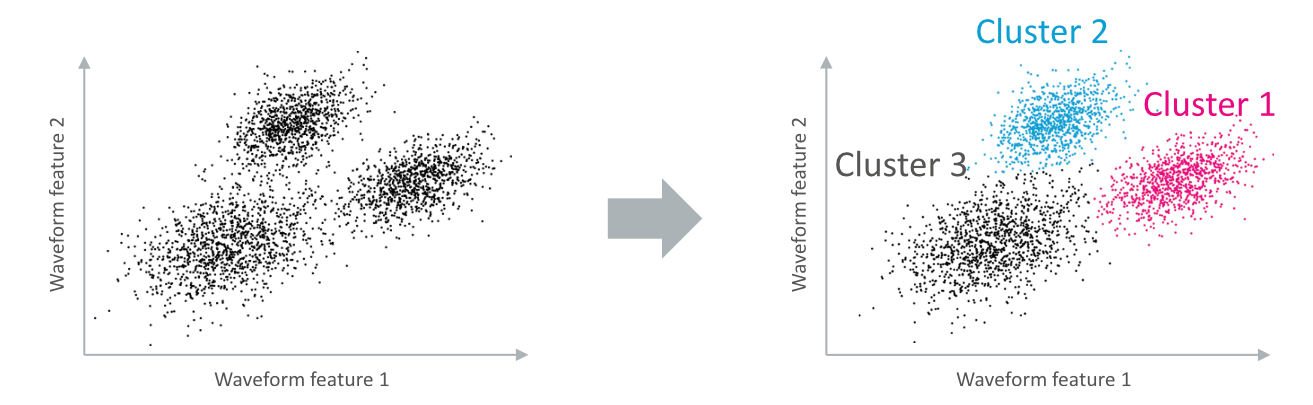

In this coding lab, we continue with the data from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-04 17:20:55CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

sklearn: 1.6.1

numpy     : 2.2.2
sklearn   : 1.6.1
matplotlib: 3.10.0
scipy     : 1.15.1

Watermark: 2.5.0



In [7]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [8]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
t = np.load("../data/nds_cl_1_spiketimes_t.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [9]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------
    n_clusters, n_dims = m.shape

    # Sample component labels using the categorical distribution
    labels = rng.choice(n_clusters, size=n_samples, p=p)

    # Sample points for each label
    x = np.empty((n_samples, n_dims))
    for i in range(n_clusters):
        # Find indices of samples to draw from cluster i
        idx = np.where(labels == i)[0]
        if len(idx) > 0:
            x[idx] = rng.multivariate_normal(mean=m[i], cov=S[i], size=len(idx))

    return labels, x

In [10]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

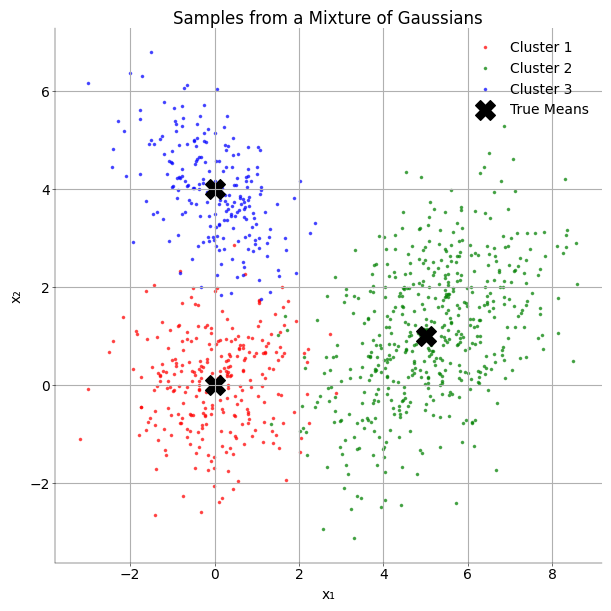

In [6]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------
colors = ["red", "green", "blue"]
labels_names = ["Cluster 1", "Cluster 2", "Cluster 3"]

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")

# scatter by true label
for i in range(3):
    ax.scatter(
        x[labels == i, 0],
        x[labels == i, 1],
        s=10,
        alpha=0.6,
        label=labels_names[i],
        color=colors[i],
    )

# overlay the means
ax.scatter(m[:, 0], m[:, 1], marker="X", s=200, c="black", label="True Means")

ax.set_title("Samples from a Mixture of Gaussians")
ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.legend()
ax.grid(True)
plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [11]:
from scipy.linalg import cholesky, solve_triangular


def initialize_with_kmeans(x, n_clusters, random_seed):
    """Initialize cluster centers using k-means++."""
    kmeans = KMeans(
        n_clusters=n_clusters, init="k-means++", n_init=10, random_state=random_seed
    )
    kmeans.fit(x)
    return kmeans.cluster_centers_


def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    rng = np.random.default_rng(random_seed)
    n_samples, n_dims = x.shape

    # Initialization
    means = (
        initialize_with_kmeans(x, n_clusters, random_seed)
        if init == "kmeans"
        else x[rng.choice(n_samples, n_clusters, replace=False)]
    )
    covariances = np.array([np.eye(n_dims) for _ in range(n_clusters)])
    weights = np.ones(n_clusters) / n_clusters

    reg_covar = 1e-6  # Regularization added to covariances
    tol = 1e-4  # Convergance tolerance

    prev_ll = -np.inf
    for step in range(n_iters):
        log_prob = np.zeros((n_samples, n_clusters))

        # E-step
        for k in range(n_clusters):
            try:
                L = cholesky(covariances[k] + reg_covar * np.eye(n_dims), lower=True)
            except np.linalg.LinAlgError:
                L = cholesky(covariances[k] + 1e-3 * np.eye(n_dims), lower=True)

            diff = x - means[k]
            y = solve_triangular(L, diff.T, lower=True)
            mahalanobis = np.sum(y**2, axis=0)
            log_det = 2.0 * np.sum(np.log(np.diag(L)))
            log_prob[:, k] = -0.5 * (
                mahalanobis + log_det + n_dims * np.log(2 * np.pi)
            ) + np.log(weights[k] + 1e-12)

        # Log-sum-exp
        max_log_prob = np.max(log_prob, axis=1, keepdims=True)
        log_responsibilities = log_prob - max_log_prob
        res = np.exp(log_responsibilities)
        res_sum = np.clip(np.sum(res, axis=1, keepdims=True), 1e-12, np.inf)
        res /= res_sum
        log_likelihood = np.sum(np.log(res_sum) + max_log_prob)

        # M-step
        Nk = np.sum(res, axis=0)
        means = (res.T @ x) / (Nk[:, np.newaxis] + 1e-12)

        covariances = np.zeros((n_clusters, n_dims, n_dims))
        for k in range(n_clusters):
            diff = x - means[k]
            weighted_diff = diff * np.sqrt(res[:, k : k + 1])
            cov_k = (weighted_diff.T @ weighted_diff) / (Nk[k] + 1e-12)
            cov_k += reg_covar * np.eye(n_dims)

            try:
                U, s, V = np.linalg.svd(cov_k)
                if np.min(s) < 1e-10 or np.max(s) / np.min(s) > 1e6:
                    cov_k += 1e-3 * np.eye(n_dims)
            except np.linalg.LinAlgError:
                cov_k += 1e-3 * np.eye(n_dims)

            covariances[k] = cov_k

        weights = Nk / n_samples

        # Reinitialize empty clusters
        empty_clusters = np.where(Nk < 1e-6)[0]
        for k in empty_clusters:
            means[k] = x[rng.choice(n_samples)]
            covariances[k] = np.eye(n_dims)
            weights[k] = 1.0 / n_clusters

        # Convergence check: relative change in LL
        if step > 0:
            rel_change = abs(log_likelihood - prev_ll) / (abs(prev_ll) + 1e-12)
            if rel_change < tol:
                break

        prev_ll = log_likelihood
        prev_means = means.copy()
        prev_covariances = covariances.copy()

    labels = np.argmax(res, axis=1)
    return labels, means, covariances, weights

Run Mixture of Gaussian on toy data

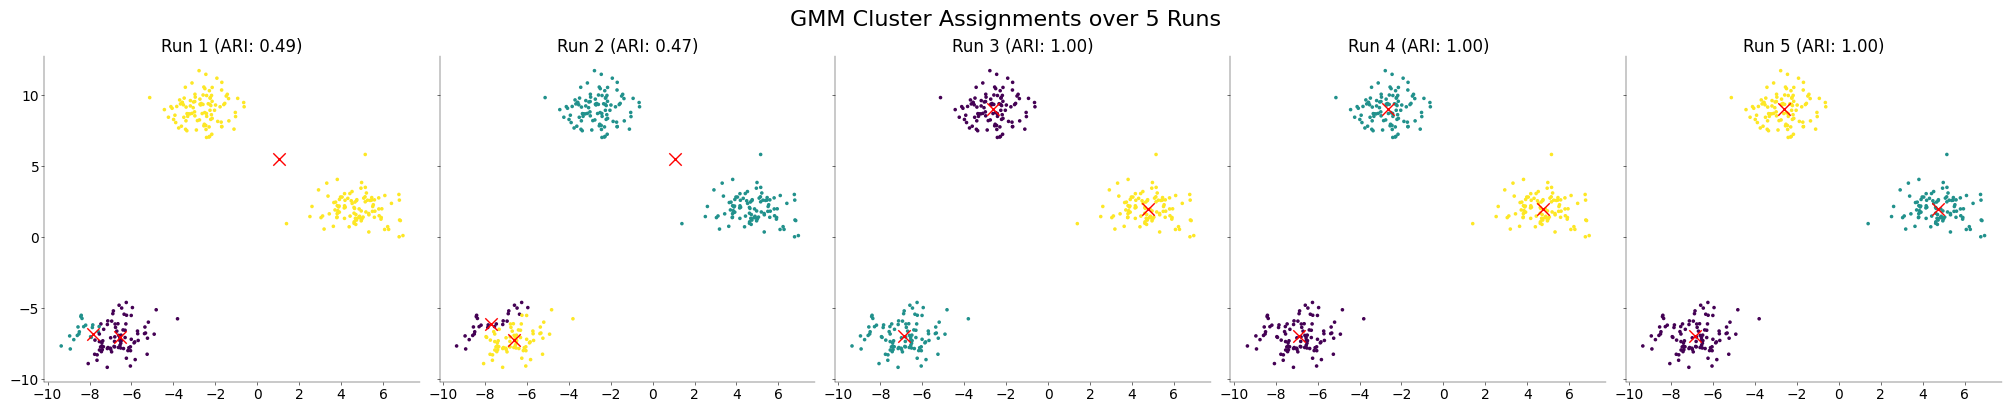

In [12]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score

# Generate toy dataset
X, true_labels = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42)


# Number of clusters
K = 3

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for i in range(5):
    seed = i  # Vary the seed
    labels, m, S, p = fit_mog(X, n_clusters=K, n_iters=10, random_seed=seed)

    ari = adjusted_rand_score(true_labels, labels)

    ax = axes[i]
    ax.set_title(f"Run {i+1} (ARI: {ari:.2f})")
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=10)
    ax.scatter(m[:, 0], m[:, 1], c="red", marker="x", s=80)

plt.suptitle("GMM Cluster Assignments over 5 Runs", fontsize=16)
plt.show()

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?

Runs 1 and 2 clearly get stuck in suboptimal local minima (ARI ≈ 0.49 and 0.47), whereas Runs 3–5 all recover the true three clusters perfectly (ARI = 1.00).  By visual inspection, I’d pick Run 3 (the first perfect recovery) as my best solution, although Runs 4 and 5 are equally good.


2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

No, the colors/label‐numbers don’t have to match, because cluster labels are only defined up to a permutation. We measure clustering accuracy with permutation‐invariant metrics (like ARI), and one can always apply a post‐hoc label matching (e.g. via the Hungarian algorithm) if one wants the colors to align for display, but that isn’t required here.

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

Q: What is the advantage of that method?
- Heavy‐tailed robustness: replacing Gaussians with Student-t components down-weights outliers automatically, giving more stable clusters in noisy spike data.
- Drift tracking: by coupling components means over time via a simple Kalman-filter step, the model lets clusters “move” slowly (e.g. electrode drift) while still sharing strength across windows.

In [13]:
# YOUR CODE HERE
from scipy.linalg import cholesky, solve_triangular
from scipy.special import digamma, gammaln
from scipy.stats import multivariate_normal


def fit_mot(
    x: np.ndarray,
    n_clusters: int,
    nu: float = 4.0,
    n_iters: int = 20,
    random_seed: int = 0,
    init: str = "kmeans",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit a mixture of Student-t distributions by EM (static version).

    Parameters
    ----------
    x            : (n, d) data
    n_clusters   : number of components
    nu           : degrees of freedom
    n_iters      : max EM iterations
    random_seed  : RNG seed
    init         : 'random' or 'kmeans'

    Returns
    -------
    labels       : (n,)
    means        : (K, d)
    covariances  : (K, d, d)
    weights      : (K,)
    """
    rng = np.random.default_rng(random_seed)
    n, d = x.shape

    # 1) init means/covs/weights
    if init == "kmeans":
        means = initialize_with_kmeans(x, n_clusters, random_seed)
    else:
        means = x[rng.choice(n, n_clusters, replace=False)]
    covs = np.array([np.cov(x, rowvar=False) for _ in range(n_clusters)])
    weights = np.ones(n_clusters) / n_clusters

    # latent “scale” variables u_{ik} for t-distribution
    # E-step will compute u and responsibilities r
    for it in range(n_iters):
        # E-step: compute responsibilities and u
        log_prob = np.zeros((n, n_clusters))
        u = np.zeros((n, n_clusters))
        for k in range(n_clusters):
            # Mahalanobis distance
            L = cholesky(covs[k], lower=True)
            diff = x - means[k]
            y = solve_triangular(L, diff.T, lower=True)
            mahal = np.sum(y**2, axis=0)

            # Student-t log-pdf
            const = (
                gammaln((nu + d) / 2)
                - gammaln(nu / 2)
                - 0.5 * d * np.log(nu * np.pi)
                - np.sum(np.log(np.diag(L)))
            )
            log_t = const - 0.5 * (nu + d) * np.log1p(mahal / nu)

            log_prob[:, k] = np.log(weights[k] + 1e-12) + log_t

            # expected scale: u = (nu+d)/(nu + mahal)
            u[:, k] = (nu + d) / (nu + mahal + 1e-12)

        # normalize responsibilities
        log_res = log_prob - log_prob.max(axis=1, keepdims=True)
        resp = np.exp(log_res)
        resp /= resp.sum(axis=1, keepdims=True)

        # M-step: update weights, means, covariances
        Nk = resp.sum(axis=0)
        weights = Nk / n

        # weighted by u
        for k in range(n_clusters):
            # update means
            means[k] = (resp[:, k] * u[:, k] @ x) / (
                np.sum(resp[:, k] * u[:, k]) + 1e-12
            )

            # update covariance
            diff = x - means[k]
            covs[k] = (resp[:, k] * u[:, k] * diff.T) @ diff
            covs[k] /= Nk[k]
            covs[k] += 1e-6 * np.eye(d)

    labels = np.argmax(resp, axis=1)
    return labels, means, covs, weights

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*


### Question (0.5 pts)

1) What is the number of parameters of the model?

$P = (K - 1) \;+\; K\,d \;+\; K\,\frac{d(d+1)}{2}$


where

- $(K - 1)$ comes from the $K$  mixture weights (they sum to 1),  
- $K\,d$ comes from the $K$  mean-vectors, and  
- $K\,\dfrac{d(d+1)}{2}$ comes from the $K$  full $d\times d$  covariance matrices (each symmetric).

($K = 3$, $d = 2$), this gives:

$$
P = (3 - 1) \;+\; 3 \cdot 2 \;+\; 3 \cdot \frac{2 \cdot 3}{2}
\;=\; 2 \;+\; 6 \;+\; 9
\;=\; 17.
$$


In [14]:
from scipy.stats import multivariate_normal
from scipy.special import logsumexp


def mog_bic(
    x: np.ndarray, means: np.ndarray, covariances: np.ndarray, weights: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------
    n, d = x.shape
    K = weights.size

    # 1) build (n,K) log-probabilities
    log_prob = np.zeros((n, K))
    for k in range(K):
        log_prob[:, k] = np.log(weights[k] + 1e-12) + multivariate_normal.logpdf(
            x, mean=means[k], cov=covariances[k], allow_singular=True
        )

    # 2) per-point log P(x_i) via logsumexp, then sum
    log_lik = np.sum(logsumexp(log_prob, axis=1))

    # 3) count parameters for FULL covariances:
    #    (K-1) weights + K*d means + K*(d*(d+1)/2) covariances
    m = (K - 1) + K * d + K * (d * (d + 1) // 2)

    # 4) BIC
    bic = -2 * log_lik + m * np.log(n)
    return bic, log_lik

In [15]:
# Range of cluster counts (K from 2 to 9)
K = np.arange(2, 10)

# Number of random seeds
num_seeds = 10

# Initialize matrices to store BIC and log-likelihood values
bic_matrix = np.zeros((num_seeds, len(K)))
ll_matrix = np.zeros((num_seeds, len(K)))

# Fit the model with multiple initializations and calculate BIC/log-likelihood
for i, k in enumerate(K):
    for j in range(num_seeds):
        # Fit GMM using fit_mog (with a fixed random seed per run)
        labels, means, covariances, weights = fit_mog(
            X, n_clusters=k, n_iters=50, random_seed=j, init="kmeans"
        )

        # Calculate BIC and log-likelihood for the fitted model
        bic_matrix[j, i], ll_matrix[j, i] = mog_bic(X, means, covariances, weights)

Optimal number of clusters by BIC = 3


/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_77314/1234725949.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


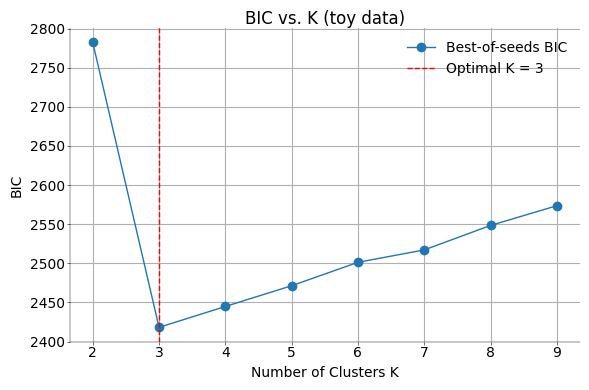

In [16]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------

# 1) Compute best‐of‐seeds BIC for each K
best_bic_per_K = np.min(bic_matrix, axis=0)

# 2) Find the K that minimizes that
optimal_k = K[np.argmin(best_bic_per_K)]
print(f"Optimal number of clusters by BIC = {optimal_k}")

# 3) Plot best‐of‐seeds curve
plt.figure(figsize=(6, 4))
plt.plot(K, best_bic_per_K, marker="o", label="Best-of-seeds BIC")
plt.axvline(optimal_k, color="red", linestyle="--", label=f"Optimal K = {optimal_k}")
plt.xlabel("Number of Clusters K")
plt.ylabel("BIC")
plt.title("BIC vs. K (toy data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

If EM converges to a poor local minimum, the log-likelihood \(L\) is lower than optimal. Since $BIC = -2L+P \log N,$ a smaller \(L\) makes –2 L larger, so the BIC for that $K$ goes up, falsely penalizing the model.


2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_

A robust $K$ is the one that consistently yields the lowest BIC across multiple restarts. In practice, for each candidate \(K\) we:
1. Run EM several times with different seeds.  
2. Record the minimum (“best-of-seeds”) BIC for that \(K\).  
3. Choose the $K$ whose best-of-seeds BIC is lowest.  
4. Optionally, check that this same $K$ is the mode of the seed-wise minimizers. 

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [17]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

# 1) PARAMETERS & DATA
K = np.arange(2, 31)  # test K = 2…30

# Load the extracted feature data
features = np.load("../data/nds_cl_1_features.npy")

# Check the shape of the data
print(f"Shape of the feature data: {features.shape}")

Shape of the feature data: (33983, 12)


In [18]:
# 2) RUN fit_mog / mog_bic LOOP

# keeping track of the best bic
bic_best = []
for k in K:
    # choose number of restarts
    seeds = 5 if k <= 20 else 3
    bic_vals = []
    for seed in range(seeds):
        labels, means, covs, weights = fit_mog(
            features,
            n_clusters=k,
            random_seed=seed,
            n_iters=100 if k <= 20 else 50,
            init="kmeans",
        )
        bic, ll = mog_bic(features, means, covs, weights)
        bic_vals.append(bic)
    bic_best.append(min(bic_vals))

bic_best = np.array(bic_best)

KeyboardInterrupt: 

Optimal number of clusters (2–30 range): 15


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_12116/2006786205.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


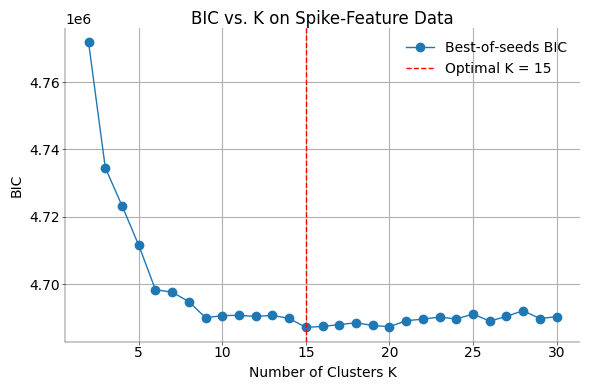

In [15]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

# 3) SELECT OPTIMAL K
opt_k = K[np.argmin(bic_best)]
print(f"Optimal number of clusters (2–30 range): {opt_k}")

# 4) PLOT BIC vs K & HIGHLIGHT opt_k
plt.figure(figsize=(6, 4))
plt.plot(K, bic_best, marker="o", label="Best‐of‐seeds BIC")
plt.axvline(opt_k, color="red", linestyle="--", label=f"Optimal K = {opt_k}")
plt.xlabel("Number of Clusters K")
plt.ylabel("BIC")
plt.title("BIC vs. K on Spike‐Feature Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Refit model with lowest BIC and plot data points

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_77314/737705914.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


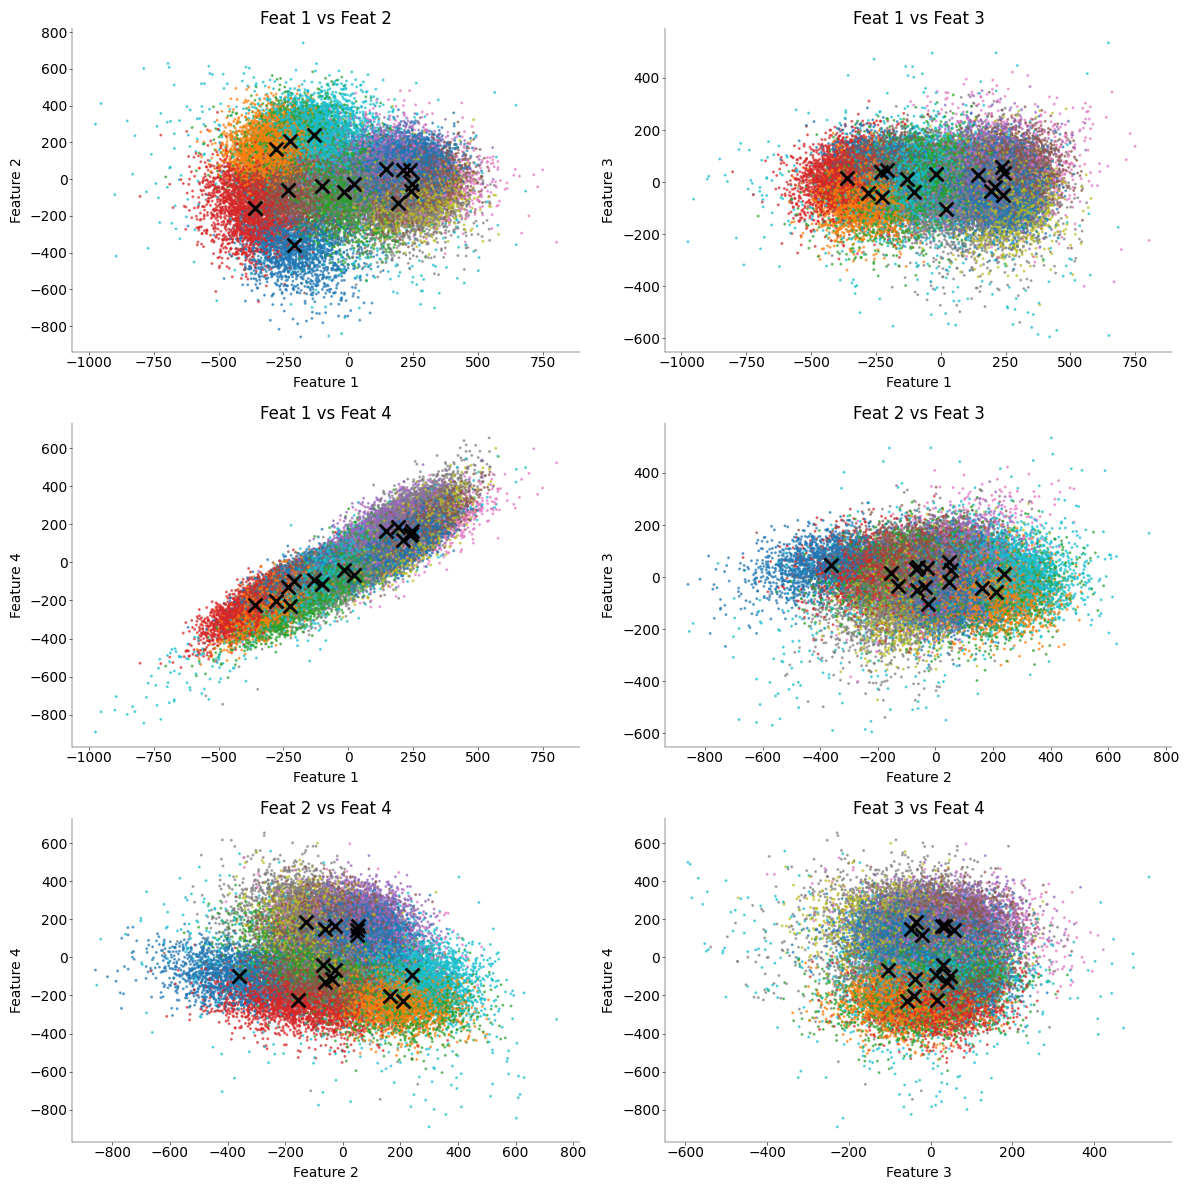

In [ ]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------
# 5) FIT FINAL MODEL & SCATTER PLOTS OF FIRST 4 FEATURES (6 PAIRWISE)
labels_final, means_final, covs_final, weights_final = fit_mog(
    features, n_clusters=opt_k, random_seed=0, n_iters=200, init="kmeans"
)

pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
plt.figure(figsize=(12, 12))
for idx, (i, j) in enumerate(pairs, start=1):
    ax = plt.subplot(3, 2, idx)
    ax.scatter(
        features[:, i], features[:, j], c=labels_final, cmap="tab10", s=5, alpha=0.6
    )
    ax.scatter(
        means_final[:, i], means_final[:, j], c="black", marker="x", s=100, linewidths=2
    )
    ax.set_xlabel(f"Feature {i+1}")
    ax.set_ylabel(f"Feature {j+1}")
    ax.set_title(f"Feat {i+1} vs Feat {j+1}")
plt.tight_layout()
plt.show()

## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [20]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    # ensure 1-d float64 vectors (seconds)
    t1 = np.asarray(spiketimes1, dtype=float).ravel()
    t2 = np.asarray(spiketimes2, dtype=float).ravel()

    # broadcasting / outer subtraction (memory friendly wrapper)
    # identical to:  t1[:, None] - t2[None, :]
    return np.subtract.outer(t1, t2)

In [23]:
opt_k

15

w.shape = (33983, 30, 4)
b: (33983, 12), s: (33983,), t: (33983,), w: (33983, 30, 4)
raw_wave_forms: (33983, 30, 4), spike_features: (33983, 12), sample_indices: (33983,), spike_seconds: (33983,)
best_labels: (33983,), best_means: (15, 12), best_covs: (15, 12, 12), best_weights: (15,)
Cluster 0 has 1739 in the range  108201 to 19197390
Cluster 1 has 5477 in the range  35893 to 19180401
Cluster 2 has 2922 in the range  25440 to 19191346
Cluster 3 has 2674 in the range  6801 to 19116254
Cluster 4 has 1476 in the range  156538 to 19162371
Cluster 5 has 2392 in the range  1125 to 19191348
Cluster 6 has 3014 in the range  1539 to 19170080
Cluster 7 has 3338 in the range  2251 to 19185295
Cluster 8 has 2311 in the range  101111 to 19199626
Cluster 9 has 716 in the range  568598 to 19105352
Cluster 10 has 1944 in the range  1769 to 19165380
Cluster 11 has 832 in the range  575483 to 19106838
Cluster 12 has 1741 in the range  75873 to 19168321
Cluster 13 has 689 in the range  573855 to 1910560

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_77314/1220748781.py:394: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


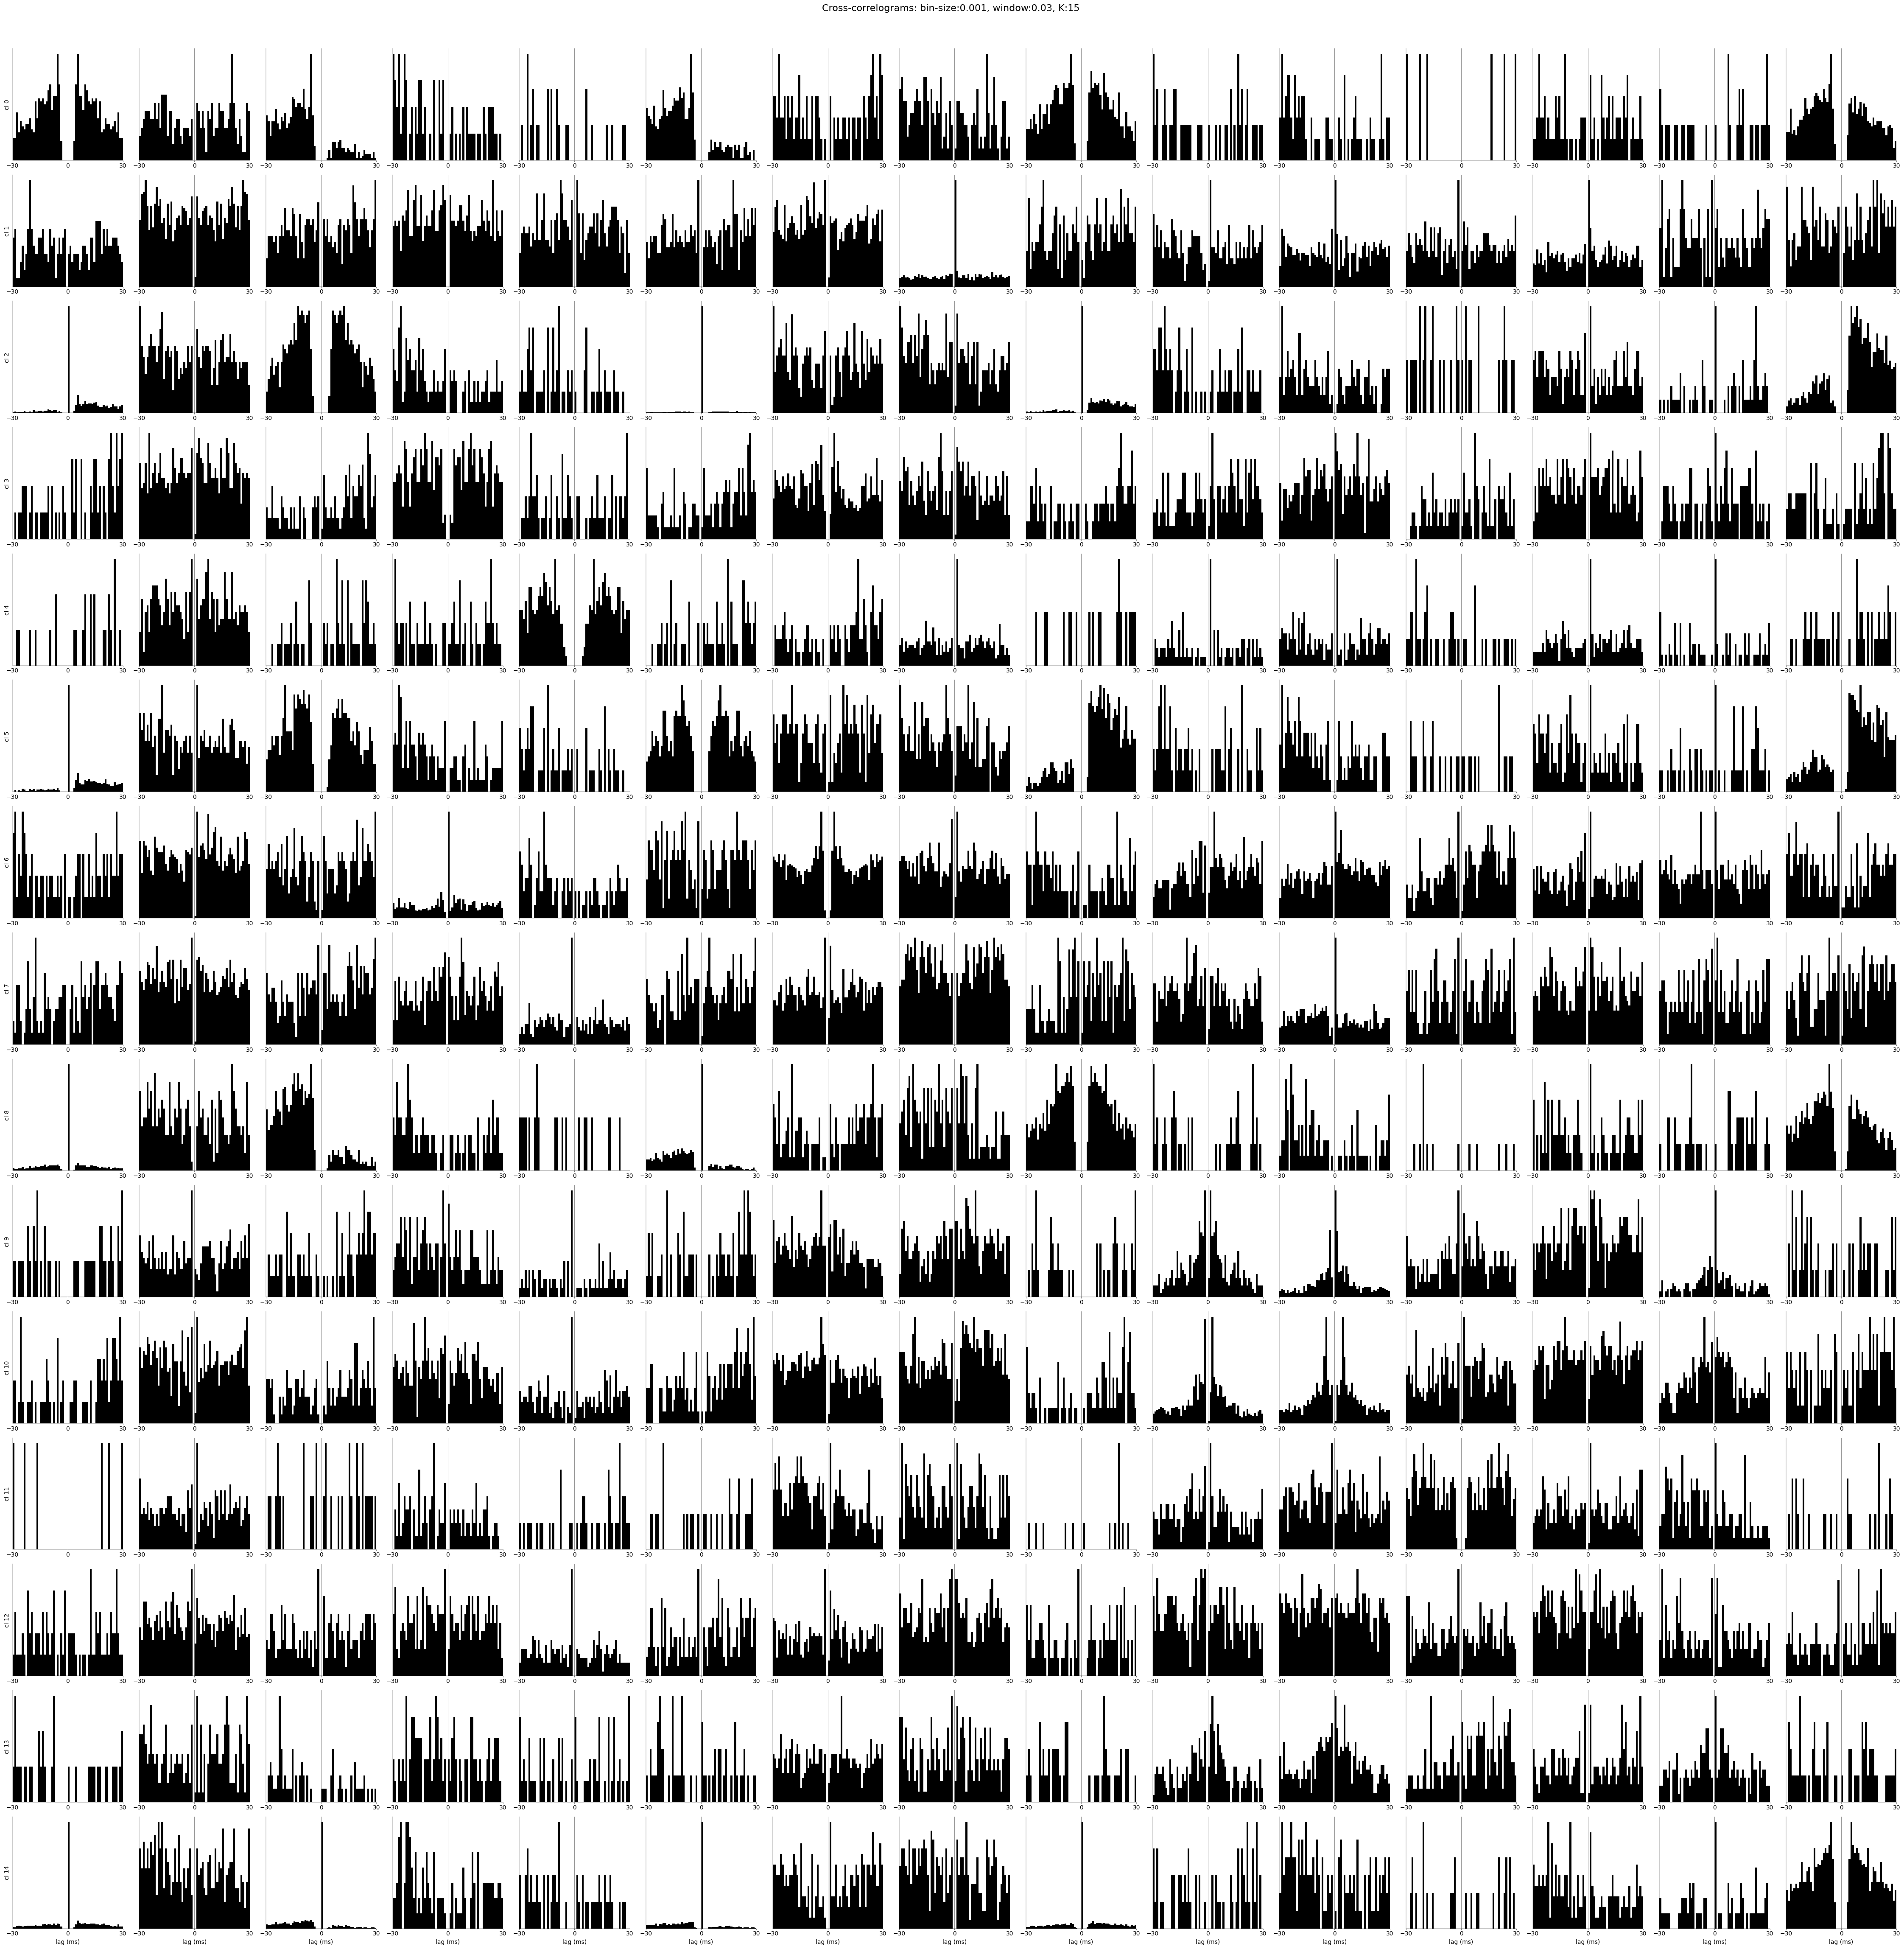

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_77314/1220748781.py:477: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


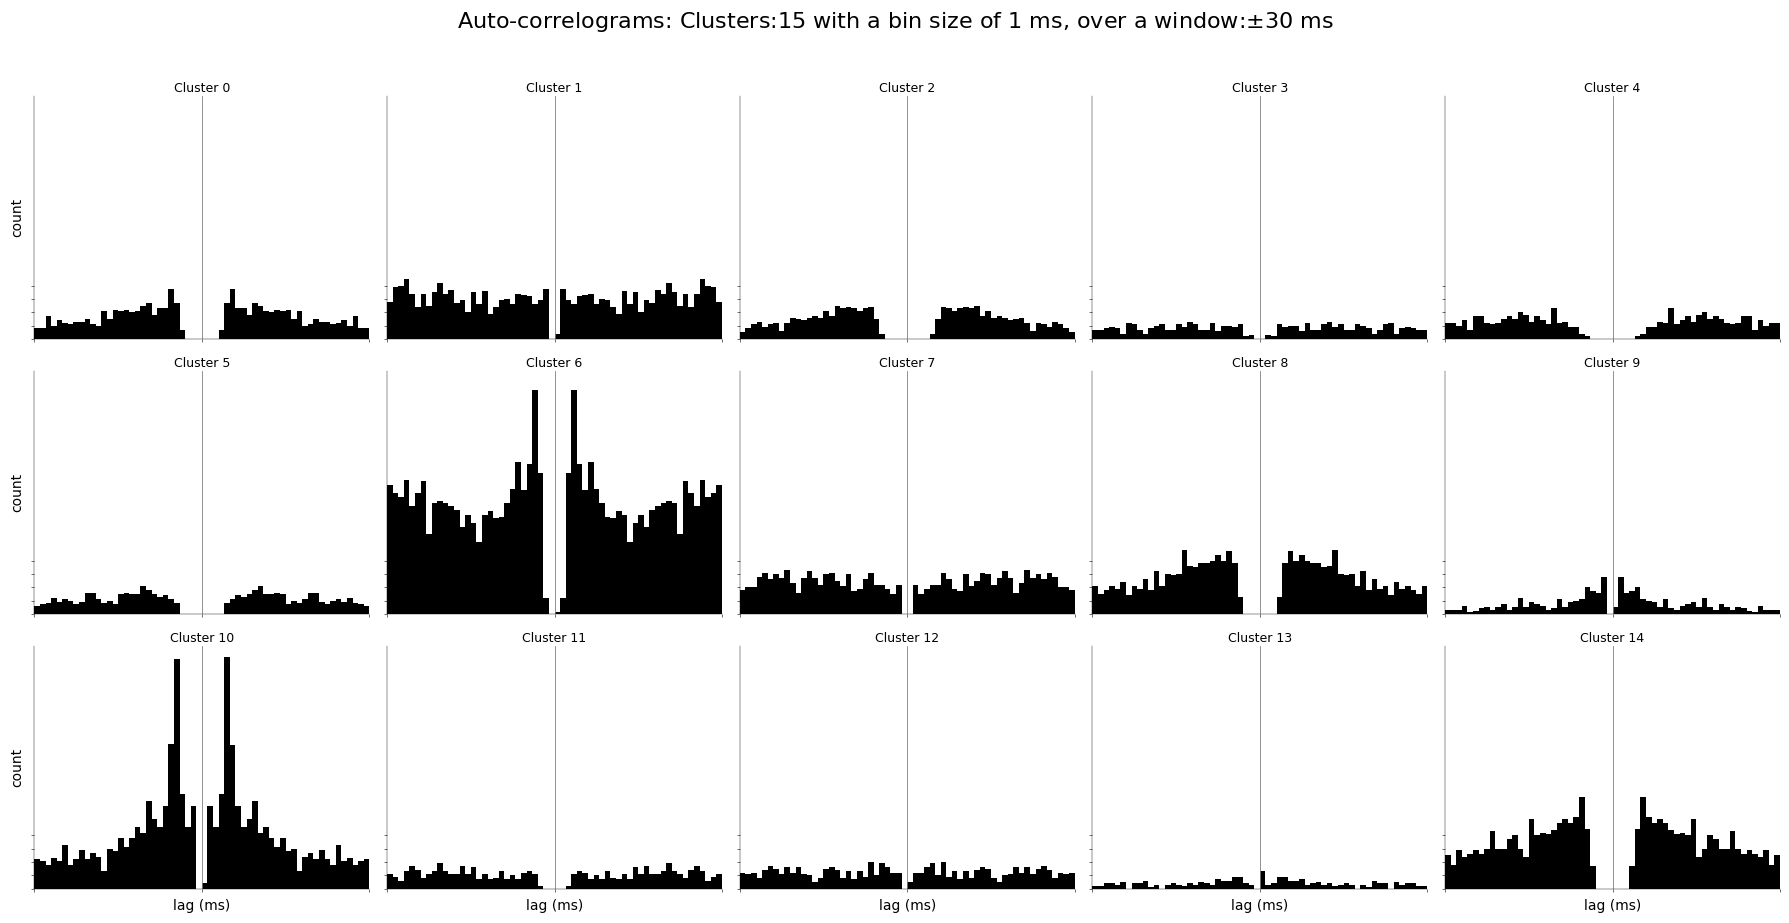

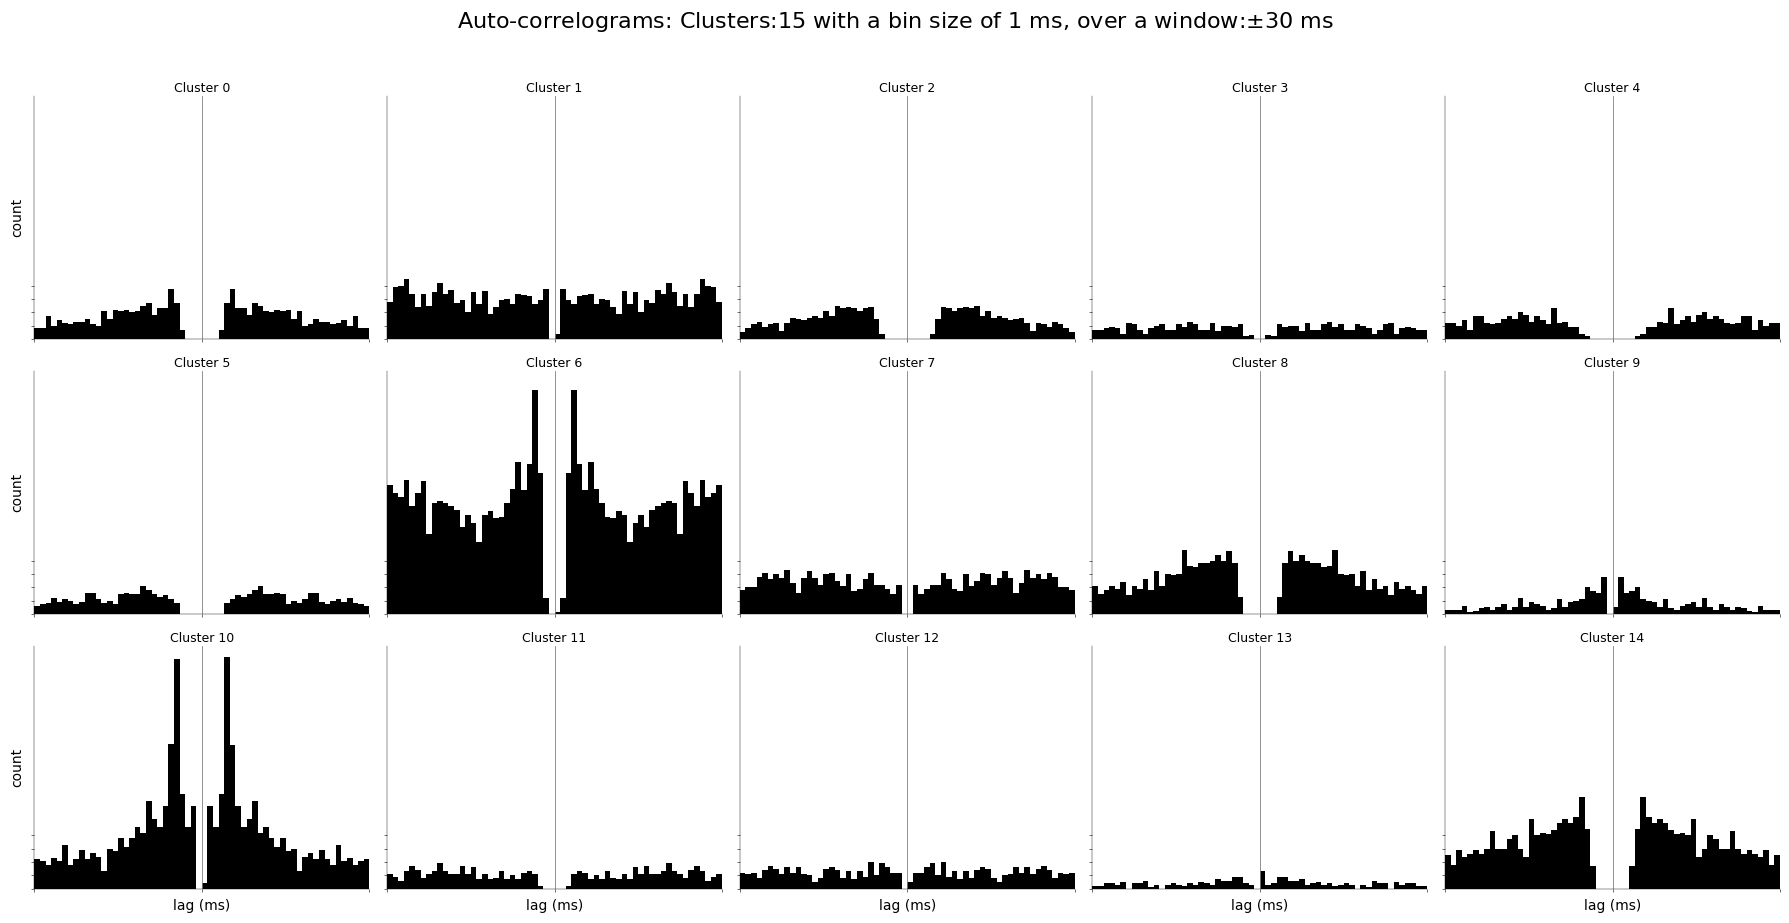

In [ ]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------


# %%
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# %%
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
t = np.load("../data/nds_cl_1_spiketimes_t.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")

assert b.shape == (33983, 12), "b should be (33983, 12)"
assert s.shape == (33983,), "s should be (33983,)"
assert t.shape == (33983,), "t should be (33983,)"

print(f"w.shape = {w.shape}")
# %%
assert w.shape == (33983, 30, 4), "w should be (33983, 30, 4)"

# %%
# Give intuitive names to the variables

print(f"b: {b.shape}, s: {s.shape}, t: {t.shape}, w: {w.shape}")
raw_wave_forms = (
    w  # (N, 30, 4) # - 33,983 spikes \times 30 time samples \times 4 channels
)
spike_features = b  # (N, 12) - 12 features per spikes  (3 principal components \times 4 channes = 12)
spike_indices = s  # 33,983 spikes, sample numbers in raw file – NOT 0…N-1 rows.
spike_seconds = t  # in seconds of spikes.
print(
    f"raw_wave_forms: {raw_wave_forms.shape}, spike_features: {spike_features.shape}, sample_indices: {spike_indices.shape}, spike_seconds: {spike_seconds.shape}"
)


# Link to previous computation
best_labels = labels_final
best_means = means_final
best_covs = covs_final
best_weights = weights_final
best_K = opt_k

# %% Assert the sizes and shapes of the variables
assert best_labels.shape == (33983,), "best_labels should be (33983,)"
assert best_means.shape == (best_K, 12), "best_means should be (K, 12)"
assert best_covs.shape == (best_K, 12, 12), "best_covs should be (K, 12, 12)"
assert best_weights.shape == (best_K,), "best_weights should be (K,)"

print(
    f"best_labels: {best_labels.shape}, best_means: {best_means.shape}, best_covs: {best_covs.shape}, best_weights: {best_weights.shape}"
)
# %%
assert best_K == 15, "Based on BIC, best_K should be 15"


# %%
def group_spike_indices_by_cluster(
    spike_indices: np.ndarray,
    labels: np.ndarray,
    n_clusters: int | None = None,
) -> np.ndarray:
    """
    Return an object-dtype array where element k is the 1-D int array of
    spike-row indices that belong to cluster k.

    All inputs **must already be NumPy arrays**.
    The output is a (n_clusters,) NumPy array with dtype=object.
    """
    # --- sanity & shape ---
    spike_indices = np.asarray(spike_indices, dtype=int).ravel()
    labels = np.asarray(labels, dtype=int).ravel()
    if spike_indices.shape != labels.shape:
        raise ValueError("spike_indices and labels need identical shape")

    if n_clusters is None:
        n_clusters = labels.max() + 1

    # --- allocate result container (object array, not Python list) ---
    grouped = np.empty(n_clusters, dtype=object)

    # --- fill per cluster ---
    for k in range(n_clusters):
        grouped[k] = spike_indices[labels == k]

    return grouped


# %%
idx_by_cluster = group_spike_indices_by_cluster(
    spike_indices, best_labels, n_clusters=best_K
)
assert idx_by_cluster.shape == (15,), "idx_by_cluster should be (15,)"

# Assert that clusters are of size from 500 to 5000 spikes per cluster.
for k in range(best_K):
    assert (
        100 <= idx_by_cluster[k].shape[0] <= 10000
    ), f"Cluster {k} has {idx_by_cluster[k].shape[0]} spikes"

for k in range(best_K):
    print(
        f"Cluster {k} has {idx_by_cluster[k].shape[0]} in the range  {idx_by_cluster[k][0]} to {idx_by_cluster[k][-1]}"
    )


# %%
# Hence we have 15 clusters of spikes, each containing between
# 500 and 5000 spikes.
#
# idx_by_cluster[k] is a 1-D array of spike indices that
# belong to the cluster.
# %%
## Task 5: Cluster separation and Correlograms
#
# As postprocessing, implement the calculation of auto- and
# cross correlograms over the spike times.
#
# Plot the (auto-/cross-) correlograms, displaying a
# time frame of -30ms to +30ms.
#
# Choose a good bin size and interpret the resulting diagrams.
#
# _Grading: 3 pts_
#
#### Hints
#
# It is faster to calculate the histogram only over the
# spike-times that are in the displayed range.
#
# Filter the spike times before calculating the histogram!_
#
# For the auto-correlogram, make sure not to include the
# time difference between a spike and itself (which would be exactly 0)_
#
# For the correlogram an efficient
# implementation is very important - looping over all
# spike times is not feasible.
# Instead, make use of numpy vectorization and broadcasting
# - you can use functions such as tile or repeat.
#
# The cross-correlogram function
# R_{uv}(\tau) = \int u(t) v(t - \tau) dt
# Histogram of $\tau = t_i - t_j$ for all spike times $t_i$ and $t_j$.
#
# Time series where events happen at discrete time points.
# The difference in all pairwise differences in spike times.
#
# 0. Start with a target and reference spike train.
# 1. Start from the reference spike train,
# 2. Then for a given reference_spike[n] we find all when relative to this spike all the
#    other spikes happened, that is what are the differences in timing between this
#    and the other spike.
# 3. Then we add to the bins where the spike was we do a histogram and add it up.
# 4. Then we move up ,
# If we do that for a spike with itself we get the autocorrelogram.
# If we do that between two neurons, we call that teh cross-correlleograms.
# So we will look at the cross and auto-correllogram between the clusters.
#
# We can detect single unit clusters, by looking at auto-correlograms.
# %%
# %%
def brute_histogram(tA, tB, edges):
    dt = (tB[:, None] - tA[None, :]).ravel()
    tol = 1e-10  # tolerance for floating point comparison
    dt = dt[(np.abs(dt) > tol) & (dt >= edges[0]) & (dt < edges[-1])]
    return np.histogram(dt, bins=edges)[0]


def simple_histogram(tA, tB, edges):
    """
    Return the histogram of (tB - tA) in the half-open bins given by *edges*.
    •  tA, tB must be 1-D and sorted (ascending seconds)
    •  dt = 0 is discarded ⇒ works for auto- and cross-correlograms
    """
    w = edges[-1]  # half-width of the window  (edges are symmetric)
    bw = edges[1] - edges[0]  # bin width
    hist = np.zeros(len(edges) - 1, dtype=int)

    for t0 in tA:
        # indices of spikes in tB that lie within [t0-w , t0+w]
        lo = np.searchsorted(tB, t0 - w, side="left")
        hi = np.searchsorted(tB, t0 + w, side="right")

        # vectorised differences, remove zeros (auto-corr)
        dt = tB[lo:hi] - t0
        tol = 1e-10  # tolerance for floating point comparison
        dt = dt[np.abs(dt) > tol]

        # map each dt to a bin and accumulate
        bins = ((dt - edges[0]) // bw).astype(int)
        np.add.at(hist, bins, 1)

    return hist


# --- The function to test ---
def fast_histogram(tA, tB, edges):
    """
    Calculates histogram counts for time differences (tB - tA)
    within the range defined by edges. Assumes tA and tB are sorted.

    Efficiently avoids calculating differences outside the window.
    Excludes zero differences (for autocorrelograms).
    """
    # Assumption 1: Inputs are sorted
    assert np.all(np.diff(tA) >= 0), "tA must be sorted!"
    assert np.all(np.diff(tB) >= 0), "tB must be sorted!"

    # Assumption 2: Edges are uniformly spaced
    bin_width = edges[1] - edges[0]
    assert np.allclose(np.diff(edges), bin_width), "Edges must be uniformly spaced!"

    # Assumption 3: Window is symmetric (optional but recommended)
    assert np.isclose(edges[0], -edges[-1]), "Edges should be symmetric around 0!"

    # Assumption 4: Inputs are 1D arrays
    assert tA.ndim == 1 and tB.ndim == 1, "tA/tB must be 1D arrays!"

    counts = np.zeros(edges.size - 1, int)
    j_left = 0
    # Determine window half-width 'w' based on edges assuming symmetric window
    # A more robust way might be needed if edges aren't symmetric around 0
    if not (np.isclose(edges[0], -edges[-1])):
        print(
            "Warning: Window edges might not be symmetric. Assuming edges[-1] defines positive window."
        )
    w = edges[-1]  # Use the positive edge limit as the window extent
    bin_width = edges[1] - edges[0]  # Assumes uniform bins

    for t0 in tA:
        # Advance j_left past spikes in tB too early for the window
        while j_left < len(tB) and tB[j_left] < t0 - w:
            j_left += 1

        # Iterate through spikes in tB potentially within the window
        j = j_left
        while j < len(tB) and tB[j] <= t0 + w:
            dt = tB[j] - t0

            # Exclude self-comparison (dt=0) and check if within overall edge bounds
            tol = 1e-10  # Tolerance for floating point comparison
            if np.abs(dt) > tol and dt >= edges[0] and dt < edges[-1]:
                # Calculate bin index based on edges
                # This assumes uniform bins starting at edges[0]
                bin_idx = int(np.floor((dt - edges[0]) / bin_width))
                # Ensure bin_idx is within the valid range (can happen due to float precision)
                bin_idx = max(0, min(bin_idx, len(counts) - 1))
                counts[bin_idx] += 1
            j += 1
    return counts


# %%
# --- Test Cases ---
# Test Case 1: Simple Autocorrelogram (tA == tB)
print("--- Test Case 1: Autocorrelogram ---")
tA_auto = np.array([0.1, 0.101, 0.105, 0.2, 0.202])
tB_auto = tA_auto
# Window: -0.005s to +0.005s (-5ms to +5ms), Bin size: 1ms
edges_auto = np.arange(-0.005, 0.005 + 0.001, 0.001)
# Edges: [-0.005, -0.004, -0.003, -0.002, -0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005]
# Bins:  | -5:-4 | -4:-3 | -3:-2 | -2:-1 | -1:0  | 0:1   | 1:2   | 2:3   | 3:4   | 4:5   |

# Expected differences (tB - tA, excluding 0):
# 0.101 - 0.1   =  0.001 (bin 5: 0-1ms)
# 0.105 - 0.1   =  0.005 (outside < edge[-1])
# 0.1   - 0.101 = -0.001 (bin 4: -1-0ms)
# 0.105 - 0.101 =  0.004 (bin 8: 3-4ms)
# 0.1   - 0.105 = -0.005 (outside >= edge[0])
# 0.101 - 0.105 = -0.004 (bin 1: -4--3ms)
# 0.202 - 0.2   =  0.002 (bin 6: 1-2ms)
# 0.2   - 0.202 = -0.002 (bin 3: -2--1ms)
# Other differences are > 0.005 or < -0.005

# Expected counts:
# Bin Indices: 0      1      2      3      4      5      6      7      8      9
# Expected:   [1,     1,     1,     1,     0,     0,     1,     1,     1,     1]

print("fast :", fast_histogram(tA_auto, tB_auto, edges_auto))
print("brute:", brute_histogram(tA_auto, tB_auto, edges_auto))
assert np.array_equal(
    fast_histogram(tA_auto, tB_auto, edges_auto),
    brute_histogram(tA_auto, tB_auto, edges_auto),
), "Test Case -1: Brute and fast histogram do not match!"


# %%
def test_random_histograms():
    rng = np.random.default_rng(0)
    tA = np.sort(rng.uniform(0, 2, 6_000))
    tB = np.sort(rng.uniform(0, 2, 6_000))

    bin_size = 0.001
    window = 0.050

    edges = np.arange(-window, window + bin_size, bin_size)

    h_fast = fast_histogram(tA, tB, edges)
    h_brute = brute_histogram(tA, tB, edges)
    h_simple = simple_histogram(tA, tB, edges)

    print(np.allclose(h_fast, h_simple))
    assert np.allclose(
        h_fast, h_simple
    ), "Random histograms do not match, h_fast, h_simple!"
    print(np.allclose(h_fast, h_brute))
    assert np.allclose(
        h_fast, h_brute
    ), "Random histograms do not match!, h_fast, h_brute"


test_random_histograms()
# %%
expected_counts_auto = np.array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1])
result_auto = fast_histogram(tA_auto, tB_auto, edges_auto)

print(f"Edges: {edges_auto}")
print(f"Result:   {result_auto}")
print(f"Expected: {expected_counts_auto}")
assert np.array_equal(result_auto, expected_counts_auto), "Test Case 1 Failed!"
print("Test Case 1 Passed!\n")

# %% # 0. choose bin size and window once
bin_size = 0.001  # 1 ms
window = 0.030  # ±30 ms
# TODO: OFF by ONE ?
num_bins = int((2 * window) / bin_size)  # Ensures exact window coverage
edges = np.arange(-window, window + bin_size, bin_size)
# Find the zero-lag bin (where dt=0 would fall, even though excluded)
# No idea why?
zero_lag_bin = np.searchsorted(edges, 0) - 1

# 1. convert sample indices → seconds, if you haven’t yet
fs = 30_000  # 30 kHz is the sampling rate
times_by_cluster = []
for idx in idx_by_cluster:
    # keep only one entry per sample index
    unique_idx = np.unique(idx)
    times_by_cluster.append(unique_idx / fs)  # seconds


def merge_close_events(t, tau=0.25e-3):
    """Collapse events that lie closer than *tau* seconds."""
    t = np.sort(t)
    keep = [0]
    for i in range(1, len(t)):
        if t[i] - t[keep[-1]] > tau:
            keep.append(i)
    return t[keep]


# TODO: Is this necessary? and is it messing with our interpretation?
tau_merge = 0.3e-3
times_by_cluster = [
    merge_close_events(idx / fs, tau=tau_merge) for idx in idx_by_cluster  # seconds
]

# 2. build the K × K correlogram matrix
centres = edges[:-1] + bin_size / 2

K = best_K
n_bins = len(edges) - 1
corr = np.empty((K, K, n_bins), int)

for i in range(K):
    for j in range(K):
        corr[i, j] = fast_histogram(times_by_cluster[i], times_by_cluster[j], edges)

np.save("corr_raw_counts.npy", corr)

# %%
fig, axes = plt.subplots(K, K, figsize=(3 * K, 3 * K))

for i in range(K):
    for j in range(K):
        ax = axes[i, j]
        counts = corr[i, j].copy()
        centre_mask = np.abs(centres) < (bin_size / 2)
        counts[centre_mask] = 0  # hide 0-lag spike
        ax.bar(centres * 1e3, counts, width=bin_size * 1e3, color="k")
        ax.set_xlim(-30, 30)
        ax.axvline(0, color="grey", lw=0.6)
        if i == K - 1:
            ax.set_xlabel("lag (ms)")
        if j == 0:
            ax.set_ylabel(f"cl {i}")
        ax.set_xticks([-30, 0, 30])
        ax.set_yticks([])
plt.tight_layout()
plt.suptitle(
    f"Cross-correlograms: bin-size:{bin_size}, window:{window}, K:{K} ",
    fontsize=16,
    y=1.02,
)
plt.savefig("correlograms.png", dpi=300)
plt.show()


# %%
# Plot Auto-Correlograms Separately
def plot_autocorrelograms(
    corr: np.ndarray,
    centres: np.ndarray,
    *,
    max_lag_ms: float = 30,
    bin_size_s: float = 1e-3,
    cols: int = 4,
    figsize: tuple = (12, 8),
    y_label: str = "count",
    x_label: str = "lag (ms)",
):
    """
    Draw the K auto-correlograms sitting on the diagonal of *corr* and
    attach nice axis labels.

    Parameters
    ----------
    corr : (K, K, n_bins) int array
        Correlogram cube (full cross-matrix).  We plot corr[k, k].
    centres : 1-D float array
        Bin-centre positions **in seconds** (same length as the last dim).
    max_lag_ms, bin_size_s, cols, figsize … see earlier version
    """
    K = corr.shape[0]
    rows = int(np.ceil(K / cols))
    width_ms = bin_size_s * 1e3

    fig, axes = plt.subplots(
        rows, cols, figsize=figsize, sharex=True, sharey=True, squeeze=False
    )

    for k in range(K):
        r, c = divmod(k, cols)
        ax = axes[r, c]

        # make a local copy so we don’t overwrite the cube
        counts = corr[k, k].copy()
        centre_mask = np.abs(centres) < (bin_size_s / 2)
        counts[centre_mask] = 0  # hide 0-lag spike

        ax.bar(centres * 1e3, counts, width=width_ms, color="k")  # convert x to ms

        ax.set_xlim(-max_lag_ms, max_lag_ms)
        ax.axvline(0, color="grey", lw=0.6)
        ax.set_title(f"Cluster {k}", fontsize=9)

        # Put tick labels only on the outer panels to avoid clutter
        if r == rows - 1:  # bottom row – show x-tick labels
            ax.set_xlabel(x_label)
            ax.set_xticks([-max_lag_ms, 0, max_lag_ms])
        else:
            ax.set_xticklabels([])

        if c == 0:  # left column – show y-tick labels
            ax.set_ylabel(y_label)
            ax.set_yticks(ax.get_yticks())  # keep ticks
        else:
            ax.set_yticklabels([])

    # delete unused axes if K is not a multiple of *cols*
    for k in range(K, rows * cols):
        fig.delaxes(axes.flat[k])

    # fig.supxlabel(x_label, fontsize=12)
    # fig.supylabel(y_label, fontsize=12, x=0.04)
    fig.suptitle(
        f"Auto-correlograms: Clusters:{K} with a bin size of {bin_size_s*1e3:.0f} ms, over a window:$\pm${max_lag_ms:.0f} ms",
        fontsize=16,
        y=1.02,
    )

    fig.tight_layout()
    return fig


def run_plot_autocorrelograms(corr, bin_size: float = 0.001, window: float = 0.030):
    """
    Run the autocorrelogram plotting function with a given bin size and window.
    """
    edges = np.arange(-window, window + bin_size, bin_size)
    centres = edges[:-1] + bin_size / 2  # seconds
    max_lag_ms = window * 1e3  # ms
    bin_size_s = bin_size
    cols = 5  # 4 plots per row
    figsize = (18, 9)
    fig = plot_autocorrelograms(
        corr,
        centres,
        max_lag_ms=max_lag_ms,
        bin_size_s=bin_size_s,
        cols=cols,
        figsize=figsize,
    )
    fig.savefig("autocorrelograms.png", dpi=300)
    return fig


fig = run_plot_autocorrelograms(corr, bin_size=bin_size, window=window)
fig.show()

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?

_YOUR ANSWER HERE_

2) Do you see cases where plural clusters might come from the same neuron?

_YOUR ANSWER HERE_

3) Do you see clusters that might contain spikes from plural neurons?

_YOUR ANSWER HERE_

4) Explain the term "refractory period" and how one can see it in this plot.

_YOUR ANSWER HERE_